# Numba Neural Network
## Curso Deep Learning y Cuda
### Trabajo Voluntario - Fundamentals Of Accelerated Computing with Cuda Python
#### Autor: Oscar Noel Amaya Garcia   
#### email: dbanshee@gmail.com

Esta práctica pretende ilustrar el uso práctico de la librería [Numba](http://numba.pydata.org/) visto en el curso adicional del *DLI* **Fundamentals of Accelerated Computing with Cuda Python**. Esta librería permite compilar y ejecutar código tanto para *CPU* como *GPU*. Se enfoca particularmente en vectores de datos. Adicionalmente permite desarrollar (y compilar *Just In Time*) **Kernels Cuda** directamente en *Python*. Gracias a esto es posible mantener de una manera simple aplicaciones *Python* que requieran de aceleracion por *GPU* pudiendo tener estas rutinas en un mismo lenguaje. 

Se implementa una red neuronal en *Python* desde 0, sin hacer uso de ningun *framework* particular. Se desarrolla todo el código necesario para realizar la definición, inferencia y entrenamiento de esta red mediante las funcionalidades de la librería **Numba**: **vectorized**, **guvectorized** y **kernels Cuda**.

In [1]:
# Librerias
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.datasets import make_moons
from numba import vectorize
from numba import guvectorize
from numba import cuda
from numba import jit
from numpy import testing
from numba import cuda, types
import math
import statistics

## Dataset

Se genera un dataset de elementos en un plano bidimensional y en 2 clases mediante la utilidad **make_circles** de la librería **sklearn**. El objetivo de la red será clasificar correctamente estos elementos una vez entrenada. Desde un punto de vista mas práctico podemos pensar que estamos identificando el núcleo de una célula que deseamos tratar, o identificar 2 grupos de enemigos enfrentados, el cual uno rodea a otro.

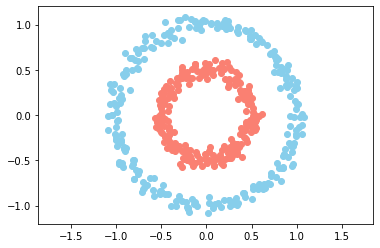

In [3]:
# Crear el Dataset
n = 500 # Muestras
p = 2   # Caracteristicas por nuestra

X, Y = make_circles(n_samples=n, factor=0.5, noise=0.05)
Y = Y[:, np.newaxis]
Y = Y.astype(np.float64)

plt.scatter(X[Y[:, 0] == 0, 0], X[Y[:, 0] == 0, 1], c="skyblue")
plt.scatter(X[Y[:, 0] == 1, 0], X[Y[:, 0] == 1, 1], c="salmon")
plt.axis("equal")
plt.autoscale()
plt.show()

## Red Neuronal

Para sacar toda la potencia a **Cuda** la memoria de la red debe definirse y explotarse en la propia **GPU**. Las únicas transferencias con el exterior serán para recibir los datos de entrenamiento una sola vez y las inferencias realizadas. Esto se realiza haciendo uso de la función **cuda.to_device** y siendo cuidadosos en el manejo de esta memoria debido a las particularidades de *Python* con las que un usuario no acostumbrado a *C/C++* puede no estar familiarizado. Un caso importante y con el que he invertido mas tiempo del deseado en depurar ha sido la asignación/copia de memoria de estos arrays.

La implementación de esta red es extremadamente simple y no pretende ser versátil ni usable en un caso real. El objetivo es centrarse en la optimización sobre *GPU* de para las operaciones matriciales necesarias en la ejecución de una red neuronal. Estos conceptos son los que podrán exportarse para el desarrollo de un framework mas completo.

In [8]:
class neural_layer_cuda():
    def __init__(self, n_conn, n_neur, act_f):
        self.act_f = act_f
        
        # Matriz Bias
        self.b = cuda.to_device((np.random.rand(1, n_neur) * 2 - 1).astype(np.float64))
        
        # Matriz de pesos
        self.W = cuda.to_device((np.random.rand(n_conn, n_neur) * 2 - 1).astype(np.float64))

def create_nn_cuda(topology, act_f):
    nn = []
    
    for l, layer in enumerate(topology[:-1]):
        nn.append(neural_layer_cuda(topology[l], topology[l+1], act_f))
    return nn

### Función de Activación

Se elige la función de activación [**sigmoide**](https://es.wikipedia.org/wiki/Funci%C3%B3n_sigmoide). Se define una operación vectorial que permite calcular en paralelo esta función para cada uno de los elementos de un vector. Para ello usamos el decorador **@vectorize** y definimos el **target=cuda** para que este código se ejecute directamente en la **GPU nVidia**.

Es necesario definir también la derivada de esta función. Ya que será necesaria en el entrenamiento de la red.

Puede consultarse el **Anexo 1** - *Las Matemáticas de una Red Neuronal al final de este cuaderno*.

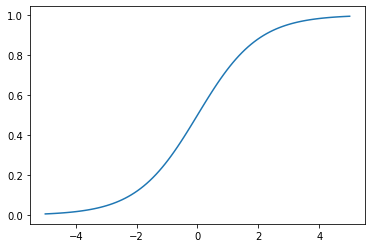

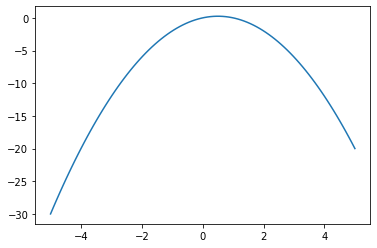

In [9]:
# Funcion sigmoide
@vectorize(['float64(float64)'], target='cuda')
def sigm_cuda_0(x):
    return 1 / (1 + math.exp(-x))

# Derivada de la Funcion sigmoide
@vectorize(['float64(float64)'], target='cuda')
def sigm_cuda_1(x):
    return x * (1 - x)

# Par de funciones
sigm_cuda = (sigm_cuda_0, sigm_cuda_1)

_x = np.linspace(-5, 5, 100)
plt.plot(_x, sigm_cuda[0](_x))
plt.show()
plt.plot(_x, sigm_cuda[1](_x))
plt.show()

### Función de Coste. Error Cuadrático medio

Se define como función de coste el [**Error cuadrático medio**](https://es.wikipedia.org/wiki/Error_cuadr%C3%A1tico_medio) que para este caso, donde el determinante de la clase a predecir depende directamente de su posición en el plano es una función adecuada.

En esta ocasión se implementa la función mediante el decorador **@guvectorized** de *Numba* que permite definir los dominios de la función realizando el acumulado de la operacion entre los elementos de dos vectores.

In [10]:
# Funcion Error Cuadrático Medio
@guvectorize(['(float64[:,:], float64[:,:], float64[:])'], '(m,n),(m,n)->()', target='cuda')
def l2_cost_cuda_0(A, B, out):
    tmp = 0.0
    for i in range(A.shape[0]):
        tmp += (A[i,0] - B[i, 0]) ** 2
    out[0] = tmp / A.shape[0]

# Funcion derivada del Error Cuadrático Medio
@vectorize(['float64(float64,float64)'], target='cuda')
def l2_cost_cuda_1(A, B):
    return A - B

l2_cost_cuda = (l2_cost_cuda_0, l2_cost_cuda_1)

#### Funciones auxiliares

Se definen algunas funciones necesarias que nativamente encajan en la filosofía de decoradores *Numba*.

In [11]:
@guvectorize(['(float64[:], float64[:], float64[:])'], '(m),(m)->(m)', target='cuda')
def vector_mult_cuda_gu(A, B, out):
    for i in range(out.shape[0]):
        out[i] = A[i] * B[i]
        
def vector_mult_cuda(A, B):
    d = cuda.device_array_like(A)
    vector_mult_cuda_gu(A, B, d)
    cuda.synchronize()
    return d

### Kernels Cuda

*Numba* permite la definición de **Kernels Cuda** directamente desde código *Python*. El compilador **JIT** (*Just In Time*) compilará este código nativamente para **Cuda** y lo cacheará para futuras ejecuciones. El uso y las utilerias son similares a las librerías en *C/C++* pero de un modo mas *Pythonico*. Incluye también algunas funciones de mas alto nivel, como **grid** o **gridsize** que simplifican el cálculo del elemento a procesar del *grid*, pero que he preferido evitar y realizar el cálculo manualmente para mostrar la similitud con la vertiente original.

<div style="text-align:center"><img src="images/numba.png" /></div>
<br/>

Los *kernels* implementan la funcionalidad necesaria para realizar el *Forward Pass* y *Back Propagation* necesarios para la inferencia y entrenamiento de la red neuronal. Es posible optimizar estos kernels ya que se apoyan en algunas operaciones previas, que si bien se ejecutan en la *GPU*, podrian ejecutarse en el mismo paso. No obstante como ya se ha comentado y debido al objetivo didáctico en el uso de varias familias de funciones de *Numba*, se mantiene así.

In [12]:
# Forward Pass
@cuda.jit
def forward_pass_cuda_k(In, W, b, out):
    i = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
    j = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y
    
    if i < In.shape[0] and j < W.shape[1]:
        tmp = np.float64(0.0)
        for k in range(In.shape[1]):
            tmp += In[i, k] * W[k, j]    
        out[i][j] = tmp + b[0, j]
        
def forward_pass_cuda(In, W, b):
    d_out = cuda.device_array(shape=(In.shape[0], W.shape[1]), dtype=np.float64)    
    threads_per_block = (32, 32)
    blocks_number = ((int(In.shape[0] / threads_per_block[0]) + 1, int(W.shape[1] / threads_per_block[1]) + 1))
    forward_pass_cuda_k[blocks_number, threads_per_block](In, W, b, d_out)
    cuda.synchronize()
    return d_out

# Gradient Update
@cuda.jit
def update_grad_cuda_k(W, b, dW, dB, lr):
    i = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
    j = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y
    
    if i == 0 and j < W.shape[1]:
        b[0, j] -= dB[0, j] * lr
    
    if i < W.shape[0] and j < W.shape[1]:
        W[i, j] -= dW[i, j] * lr
        
def update_grad_cuda(W, b, dW, dB, lr):
    threads_per_block = (32, 32)
    blocks_number = ((int(W.shape[0] / threads_per_block[0]) + 1, int(W.shape[1] / threads_per_block[1]) + 1))
    update_grad_cuda_k[blocks_number, threads_per_block](W, b, dW, dB, lr)
    cuda.synchronize()

# Matrix Multiplication A @ B
@cuda.jit
def matmult_cuda_k(A, B, out):
    i = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
    j = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y
    
    if i < A.shape[0] and j < B.shape[1]:
        tmp = 0.
        for k in range(A.shape[1]):
            tmp += A[i, k] * B[k, j]    
        out[i][j] = tmp

def matmult_cuda(A, B):
    d_out = cuda.device_array(shape=(A.shape[0], B.shape[0]), dtype=np.float64)    
    threads_per_block = (32, 32)
    blocks_number = ((int(A.shape[0] / threads_per_block[0]) + 1, int(B.shape[1] / threads_per_block[1]) + 1))
    matmult_cuda_k[blocks_number, threads_per_block](A, B, d_out)
    cuda.synchronize()
    return d_out

# Matrix Multiplication (B Transpose) A @ B.T
@cuda.jit
def matmult_trans_cuda_k(A, B, out):
    i = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
    j = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y
    
    if i < A.shape[0] and j < B.shape[0]:
        tmp = 0.
        for k in range(A.shape[1]):
            tmp += A[i, k] * B[j, k]    
        out[i][j] = tmp

def matmult_trans_cuda(A, B):
    d_out = cuda.device_array(shape=(A.shape[0], B.shape[0]), dtype=np.float64)    
    threads_per_block = (32, 32)
    blocks_number = ((int(A.shape[0] / threads_per_block[0]) + 1, int(B.shape[0] / threads_per_block[1]) + 1))
    matmult_trans_cuda_k[blocks_number, threads_per_block](A, B, d_out)
    cuda.synchronize()
    return d_out

# Matrix Multiplication (A Transpose) A.T @ B
@cuda.jit
def matmult_trans2_cuda_k(A, B, out):
    i = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
    j = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y
    
    if i < A.shape[1] and j < B.shape[1]:
        tmp = 0.
        for k in range(A.shape[0]):
            tmp += A[k, i] * B[k, j]
        out[i][j] = tmp

def matmult_trans2_cuda(A, B):
    d_out = cuda.device_array(shape=(A.shape[1], B.shape[1]), dtype=np.float64)    
    threads_per_block = (32, 32)
    blocks_number = ((int(A.shape[0] / threads_per_block[0]) + 1, int(B.shape[0] / threads_per_block[1]) + 1))
    matmult_trans2_cuda_k[blocks_number, threads_per_block](A, B, d_out)
    cuda.synchronize()
    return d_out

# Vector Mean with keep columns
@cuda.jit
def mean_keep_col_cuda_k(A, out):
    i = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
    if i < A.shape[1]:
        tmp = 0.0
        for k in range(A.shape[0]):
            tmp += A[k, i]  
        out[0][i] = tmp / A.shape[0]

def mean_keep_col_cuda(A):
    d_out = cuda.device_array(shape=(1, A.shape[1]), dtype=np.float64)    
    threads_per_block = 32
    blocks_number = int((A.shape[1] / threads_per_block) + 1)
    mean_keep_col_cuda_k[blocks_number, threads_per_block](A, d_out)
    cuda.synchronize()
    return d_out

# Copy Matrix    
@cuda.jit
def mat_copy_k(A, out):
    i = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
    j = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y
    
    if i < A.shape[0] and j < A.shape[1]:
        out[i, j] = A[i, j]

def mat_copy(A):
    d_out = cuda.device_array(shape=(A.shape[0], A.shape[1]), dtype=np.float64)    
    threads_per_block = (32, 32)
    blocks_number = ((int(A.shape[0] / threads_per_block[0]) + 1, int(A.shape[1] / threads_per_block[1]) + 1))
    mat_copy_k[blocks_number, threads_per_block](A, d_out)
    cuda.synchronize()
    return d_out

## Función Entrenamiento

La siguiente función entrena la red y realiza la predicción. Permite establecerle el [*Learning Rate*](https://en.wikipedia.org/wiki/Learning_rate) y la *función de coste*. Se ha documentado el código con los equivalentes en sus operaciones *Numpy* para mejorar la compresion de las operaciones que se realizan en el código *Numba*.

In [16]:
def train_cuda(neural_net, X, Y, f_cost, lr=0.5, train=True):
    
    # Forward pass
    #out = [(z0, a0), (z1, a1), ...]
    out = [(None, X)]
    for l, layer in enumerate(neural_net):
        #   out[-1][1] @ neural_net[l].W + neural_net[l].b
        z = forward_pass_cuda(out[-1][1], neural_net[l].W, neural_net[l].b)
        
        #   neural_net[l].act_f[0](z)
        a = neural_net[l].act_f[0](z)
        cuda.synchronize()    
        out.append((z, a))
        
    res = out[-1][1]
    
    if train:
        # Backward pass
        deltas = []
        
        for l in reversed(range(0, len(neural_net))):        
            z = out[l+1][0]
            a = out[l+1][1]
            
            if l == len(neural_net) - 1: 
                # Calcular delta ultima capa
                
                # f_cost[1](a, Y) * neural_net[l].act_f[1](a)
                fc = f_cost[1](a, Y)
                act = neural_net[l].act_f[1](a)
                cuda.synchronize()
                
                d_gpu = vector_mult_cuda(fc, act)
                deltas.insert(0, d_gpu)   
            else:
                # deltas[0] @ _W.T  * neural_net[l].act_f[1](a)
                d_gpu = vector_mult_cuda(matmult_trans_cuda(deltas[0], _W), neural_net[l].act_f[1](a))
                deltas.insert(0, d_gpu)

            _W = mat_copy(neural_net[l].W)   
          
            # neural_net[l].b - np.mean(deltas[0], axis=0, keepdims=True) * lr
            # neural_net[l].W - out[l][1].T @ deltas[0] * lr 
            dW = matmult_trans2_cuda(out[l][1], deltas[0])
            dB = mean_keep_col_cuda(deltas[0])
            update_grad_cuda(neural_net[l].W, neural_net[l].b, dW, dB, lr)
            
    return out[-1][1]

### Ejecución Entrenamiento

Se realiza el entrenamiento de la red y se evalua periódicamente un espacio cartesiano con los valores predichos para mostrar bajo un mapa de color el aprendizaje de la red. Finalmente se observará como la region se adapta a los puntos de ambas clases. Y todo ello en un código **100% Python**!!

De especial relevancia migrar los datos de entrenamiento previamente de la *CPU* a la *GPU* y que todo el entrenamiento se realice con las minima intercomunicación entre ambas memorias.

Ni la arquitectura de la red ni el numero de neuronas es especialmente complejo o elevado, ni se necesita para este *toy example*.

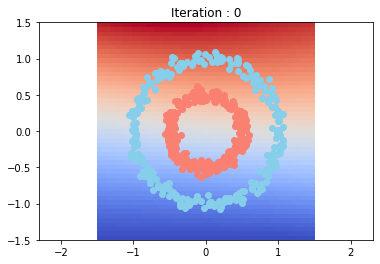

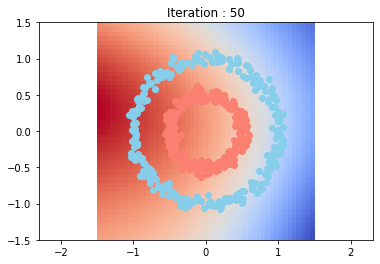

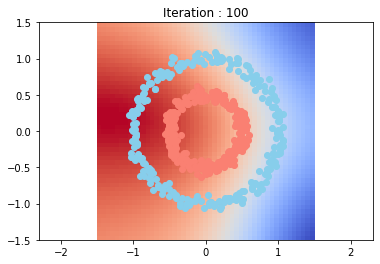

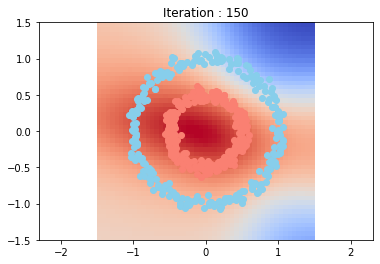

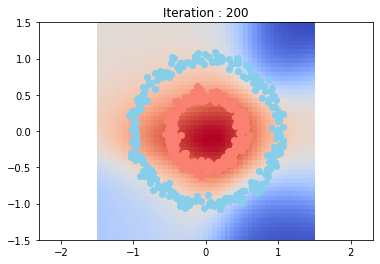

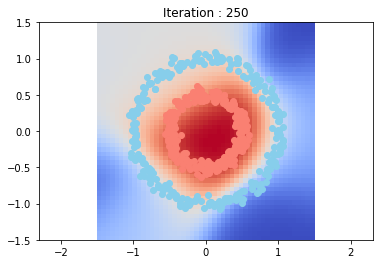

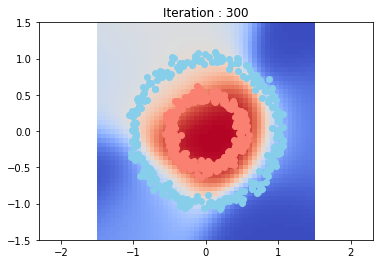

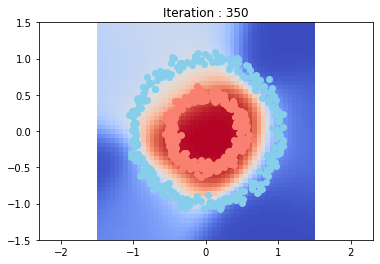

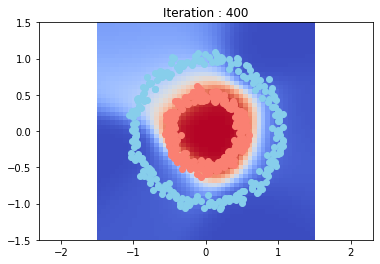

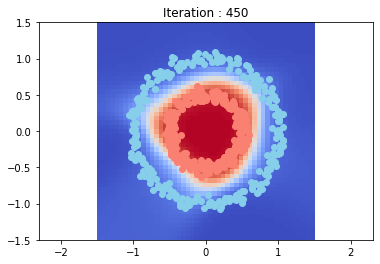

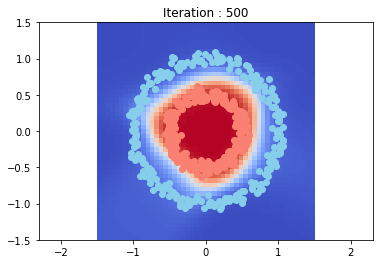

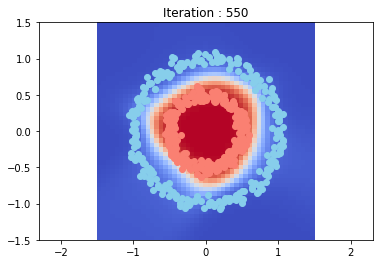

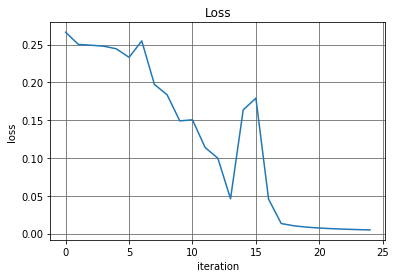

o


In [33]:
import time
import timeit
from IPython.display import clear_output

p = 2
topology = [p, 4, 8, 1]
neural_n = create_nn_cuda(topology, sigm_cuda)

loss = []
min_loss = 0.005

try:
    # Test Space
    res = 50
    _x0 = np.linspace(-1.5, 1.5, res)
    _x1 = np.linspace(-1.5, 1.5, res)
    
    space_X = []
    for i0, x0 in enumerate(_x0):
        for i1, x1 in enumerate(_x1):
            space_X.append([x1, x0])

    space_X = np.array(space_X)
    space_X = cuda.to_device(space_X)
    
    # Inputs Outputs
    d_X = cuda.to_device(X)
    d_Y = cuda.to_device(Y)

    for i in range(5000):
    
        # Train
        pY = train_cuda(neural_n, d_X, d_Y, l2_cost_cuda, lr=np.float64(0.05), train=True)
        
        if i % 25 == 0:
            d_loss = l2_cost_cuda[0](pY, d_Y)
            loss.append(d_loss.copy_to_host())

        if i % 50 == 0:    
            color = np.zeros((res, res))
            for i0, x0 in enumerate(_x0):
                for i1, x1 in enumerate(_x1):
                    entry = cuda.to_device(np.array([[x1, x0]]).astype(np.float64))
                    color[i0, i1] = train_cuda(neural_n, entry, None, l2_cost_cuda, train=False).copy_to_host()[0][0]
                    
            plt.pcolormesh(_x1, _x0, color, cmap="coolwarm")
            plt.axis("equal")

            plt.scatter(X[Y[:,0] == 0, 0], X[Y[:,0] == 0, 1], c="skyblue")
            plt.scatter(X[Y[:,0] == 1, 0], X[Y[:,0] == 1, 1], c="salmon")
            plt.title('Iteration : {}'.format(i))
            plt.show()

        closs = loss[-1]
        if loss[-1] <= min_loss:
            print("Min Loss Reached. Stoping trainig at epoch {}".format(i))
            break;
except KeyboardInterrupt:
    None

plt.plot(range(len(loss)), loss)
plt.title("Loss")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.show()

closs = loss[-1]
print("Loss: {}".format(closs)[1])

## Conclusiones

La libreria **Numba** acerca al desarrollador de *Python* buena parte de la potencia de la programación sobre **GPUs** y *nVidia Cuda* en particular. Permite tener todo el código unificado sobre un mismo lenguaje e integrado sobre la misma aplicación. Es una gran opción para no renunciar a la aceleración *hardware* hasta en las en ocasiones en que la integración con un programa o libreria de núcleo *C/C++* no mereciera la pena. 

Me parece un recurso especialmente útil para la comunidad *Data Science*, generalmente con conocimientos de *Python* pero no excesivamente de *C*. Con el uso de los decoradores *Universal Functions* es posible acelerar código que usualmente quedaría ejecutado en *CPU* con un esfuerzo mínimo.

Destacar también que *Numba* no es la unica mánera de utilizar *Cuda* dede *Python*. Y no siendo *Numba* la que mejor rendimiento ofrece. Sin embargo si permite programarse integramente en lenguaje Python. Dos de las opciones mas conocidas son [CuPy](https://cupy.chainer.org/) y [PyCuda](https://documen.tician.de/pycuda/)

## Anexo 1 - Las matemáticas de una red neuronal

<center><img src='images/neurona.png'></center>

Se define el cálculo de una neurona en la capa **L** como la suma ponderada **Z** de sus pesos por las entradas (la salida de la capa anterior):
$$
Z^L = W^L . a^{L-1} + b^L
$$


Al resultado de esta suma pasa por la función de activación **a**, y a esta se calcula el coste **C**
$$
\begin{equation}
C(a(Z^L))
\end{equation}
$$

#### Algoritmo Backpropagation

La salida de la red calculado por la función de error (o coste)

¿Como varía el error ante un cambio del parametro W y b (los pesos y el bias de la red)?
$$
\begin{align}
\frac{\partial C}{\partial w}   \frac{\partial C}{\partial b}
\end{align}
$$

Indicamos el número de la capa en las derivadas parciales
$$
\begin{align}
\frac{\partial C}{\partial w^l}   \frac{\partial C}{\partial b^l}
\end{align}
$$

Calculamos estas derivadas en la última capa.

<center><img src='data/costeultimacapa.pngkk'></center>

Aplicamos Derivada de una composición de funciones

$$
\frac{\partial C}{\partial b^L} = \frac{\partial C}{\partial a^L} . \frac{\partial a^L}{\partial z^L} . \frac{\partial z^L}{\partial b^L} 
$$


$$
\frac{\partial C}{\partial w^L} = \frac{\partial C}{\partial a^L} . \frac{\partial a^L}{\partial z^L} . \frac{\partial z^L}{\partial w^L} 
$$


Calculamos las derivadas parciales

1. Derivada de la función de coste. \
    Suponiendo **C** como el error cuadratico medio. Coste de la neurona *j* en la capa *L*:
    $$
    \begin{equation}
    C(a_{j}^{L}) = \frac{1}{2} \sum_{n=1}(y_{j} - a_{j}^L)^2
    \end{equation}
    $$
    \
    Su derivada resulta:
    $$
    \frac{\partial C}{\partial a_{j}^{L}} = (a_{j}^{L} - y_{j})
    $$
    
2. Derivada de la activacion **a** respecto a la suma ponderada **z**
    Suponiendo **a** como la función sigmoide:
    $$
    \begin{equation}
    a^L(z^L) = \frac{1}{1 + e^{-z^L}}
    \end{equation}
    $$
    \
    Su derivada resulta:
    $$
    \frac{\partial a^L}{\partial z^L} = a^L(z^L)(1 - a^L(z^L))
    $$

3. Derivada de la suma ponderada **z** respecto a una variacion de los parametros **W**(pesos) y el **b**(sesgo) en la salida de la capa anterior.
    $$
    \begin{equation}
    z^L = \sum_{i}(a_{i}^{L-1} w_{i}^{L} + b^{L})
    \end{equation}
    $$
    
    Sus derivadas resultan
    $$
    \begin{equation}
    \frac{\partial z^L}{\partial b^L} = 1
    \end{equation}
    $$
    
    $$
    \begin{equation}
    \frac{\partial z^L}{\partial w^L} = a_{i}^{L-1}
    \end{equation}
    $$
    
Se define la función **delta** como el error asociado a una neurona en la capa *L* como:
$$
\begin{equation}
 \frac{\partial C}{\partial a^L} . \frac{\partial a^L}{\partial z^L}  = \frac{\partial C}{\partial z^L} = \delta^L
\end{equation}
$$

Reagrupando las ecuaciones obtenemos:

$$
\frac{\partial C}{\partial b^L} = \delta^L . \frac{\partial z^L}{\partial b^L} 
$$

$$
\frac{\partial C}{\partial w^L} = \delta^L . \frac{\partial z^L}{\partial w^L} 
$$


Sustituyendo:
$$
\frac{\partial C}{\partial b^L} = \delta^L . 1
$$

$$
\frac{\partial C}{\partial w^L} = \delta^L . a_{i}^{L-1}
$$

Con esto tenemos las derivadas parciales para la **última** capa.

$$
\begin{equation}
\delta^L = \frac{\partial C}{\partial a^L} . \frac{\partial a^L}{\partial z^L}
\end{equation}
$$

$$
\frac{\partial C}{\partial b^L} = \delta^L
$$

$$
\frac{\partial C}{\partial w^L} = \delta^L . a_{i}^{L-1}
$$


Planteamos de manera genérica las derivadas para la capa **L-1**:

Función de coste:
(Cuidado, se utiliza **a** como funcion y como vector).

$$
\begin{equation}
C(a^L(Z^L)) = C(a^L(W^L . a^{L-1} + b^L)) = C(a^L(W^L . a^{L-1}(W^{L-1}.a^{L-2} + b^{L-1})  + b^L))
\end{equation}
$$

Sus derivadas parciales serian:

$$
\begin{equation}
\frac{\partial C}{\partial b^{L-1}} = \frac{\partial C}{\partial a^L} . \frac{\partial a^L}{\partial z^L} . \frac{\partial z^L}{\partial a^{L-1}} . \frac{\partial a^{L-1}}{\partial z^{L-1}} . \frac{\partial z^{L-1}}{\partial b^{L-1}}
\end{equation}
$$

$$
\begin{equation}
\frac{\partial C}{\partial w^{L-1}} = \frac{\partial C}{\partial a^L} . \frac{\partial a^L}{\partial z^L} . \frac{\partial z^L}{\partial a^{L-1}} . \frac{\partial a^{L-1}}{\partial z^{L-1}} . \frac{\partial z^{L-1}}{\partial b^{w-1}}
\end{equation}
$$

Reemplazando del conocimiento anterior:

$$
\begin{equation}
\frac{\partial C}{\partial b^{L-1}} = \delta^L . \frac{\partial z^L}{\partial a^{L-1}} . \frac{\partial a^{L-1}}{\partial z^{L-1}} . 1
\end{equation}
$$

$$
\begin{equation}
\frac{\partial C}{\partial w^{L-1}} = \delta^L . \frac{\partial z^L}{\partial a^{L-1}} . \frac{\partial a^{L-1}}{\partial z^{L-1}} . a^{L-2}
\end{equation}
$$


$$
\delta^{L-1} = \frac{\partial C}{\partial z^{L-1}}
$$


Concluimos: 

1. Cómputo del error de la última capa
    $$
    \begin{equation}
    \delta^L = \frac{\partial C}{\partial a^L} . \frac{\partial a^L}{\partial z^L}
    \end{equation}
    $$
    
2. Retropropagamos el error a la capa anterior
    $$
    \begin{equation}
    \delta^{l-1} = W^l \delta^l . \frac{\partial a^{l-1}}{\partial z^{l-1}}
    \end{equation}
    $$
    
3. Calculamos las derivadas de la capa utilizando el error
    $$
    \begin{equation}
    \delta^{l-1} = \frac{\partial C}{\partial b^{l-1}}
    \end{equation}
    $$
    
    $$
    \begin{equation}
    \delta^{l-1} a^{l-2} = \frac{\partial C}{\partial w^{l-1}}
    \end{equation}
    $$